In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, average_precision_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay)

In [30]:
class LassoHateSpeech:
    """Lasso model using sentence embeddings to detect hate speech."""

    def __init__(self):
        """Initialize classifier with Lasso model and encoder."""
        self.encoder = SentenceTransformer("all-MiniLM-L6-v2")
        self.model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
        self.best_threshold = 0.25

    def embed(self, texts: pd.Series) -> np.ndarray:
        """Embed text using SentenceTransformer."""
        return self.encoder.encode(texts.tolist(), show_progress_bar=False)

    def train(self, X: pd.Series, y: pd.Series) -> None:
        """Train the logistic regression model."""
        X_embed = self.embed(X)
        self.model.fit(X_embed, y)

    def predict_proba(self, X: pd.Series) -> pd.Series:
        """Predict probability of hate speech."""
        X_embed = self.embed(X)
        proba = self.model.predict_proba(X_embed)[:, 1]
        return pd.Series(proba, index=X.index)

    def evaluate(self, X_test: pd.Series, y_test: pd.Series, metric: str = "accuracy") -> None:
        """
        Evaluate model and print classification report using optimal threshold.

        Args:
            X_test (pd.Series): Test input texts.
            y_test (pd.Series): True binary labels.
            metric (str): Metric to optimize threshold on ('accuracy', 'precision', 'recall').
        """
        proba = self.predict_proba(X_test)
        y_pred = (proba >= 0.25).astype(int)
        print(classification_report(y_test, y_pred))

In [31]:
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv", sep = ";")

X_train = train_df["text"]
y_train = train_df["label"]

model = LassoHateSpeech()
model.train(X_train, y_train)

X_test = test_df["comment"]
y_test = (test_df["isHate"] >= 0.25).astype(int)

model.evaluate(X_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.34      0.48       475
           1       0.61      0.94      0.74       523

    accuracy                           0.65       998
   macro avg       0.72      0.64      0.61       998
weighted avg       0.71      0.65      0.61       998



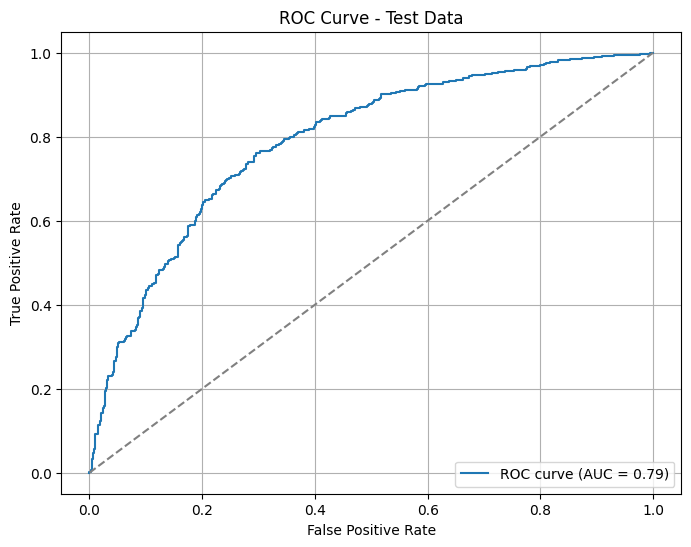

In [32]:
test_probs = model.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Data")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

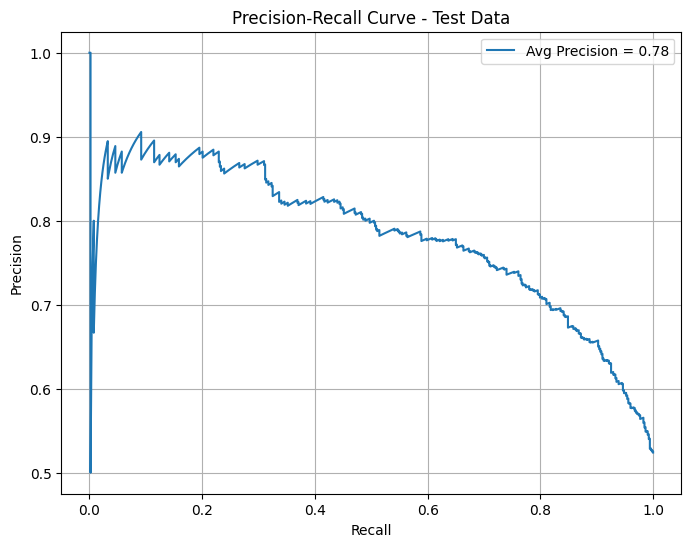

In [33]:
precision, recall, _ = precision_recall_curve(y_test, test_probs)
avg_precision = average_precision_score(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test Data")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

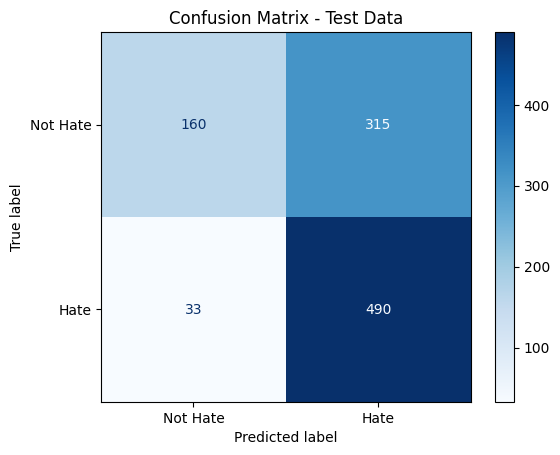

In [34]:
y_test_pred = (test_probs >= 0.25).astype(int)

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Data")
plt.grid(False)
plt.show()